In [5]:
#pennylane optimization
import pennylane as qml
import pennylane.numpy as np

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(theta):
    qml.PauliX(wires=0)
    qml.RY(theta,wires=0)
    return qml.expval(qml.PauliZ(0))
circuit(0.1)

thetas = np.linspace(-np.pi, np.pi,50)
measurements = []
for theta in thetas:
    measurements.append(circuit(theta))

theta = np.array([-2],requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize = 0.1)
n_it = 100
for it in range(n_it):
    theta,prev_cost=opt.step_and_cost(circuit,theta)
    if it%10==0:
        print('Theta: ', theta, 'Cost', circuit(theta))

Theta:  [-1.90907026] Cost [0.33185934]
Theta:  [-0.95268251] Cost [-0.579499]
Theta:  [-0.35999832] Cost [-0.93589741]
Theta:  [-0.12693105] Cost [-0.99195506]
Theta:  [-0.04431925] Cost [-0.99901806]
Theta:  [-0.01545577] Cost [-0.99988056]
Theta:  [-0.0053892] Cost [-0.99998548]
Theta:  [-0.0018791] Cost [-0.99999823]
Theta:  [-0.0006552] Cost [-0.99999979]
Theta:  [-0.00022846] Cost [-0.99999997]


In [ ]:
fig, ax = qml.draw_mpl(circuit)(0)
fig.show()

In [17]:
#custom optimizer gradient from scratch

import pennylane as qml
import pennylane.numpy as np

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(theta):
    qml.PauliX(wires=0)
    qml.RY(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

def cost(theta):
    return circuit(theta)

def gradient_descent(theta, learning_rate, n_iterations):
    for it in range(n_iterations):
        # Compute the gradient
        grad = (cost(theta + np.pi/2) - cost(theta - np.pi/2)) / 2

        # Update the parameters
        theta = theta - learning_rate * grad

        if it % 10 == 0:
            print('Iteration {}: Theta = {}, Cost = {}'.format(it, theta, cost(theta)))

    return theta

# Initial parameters
theta_init = -2.0
learning_rate = 0.1
n_iterations = 100

# Perform gradient descent
final_theta = gradient_descent(theta_init, learning_rate, n_iterations)

# Print the final result
print('Final Result: Theta = {}, Cost = {}'.format(final_theta, cost(final_theta)))


Iteration 0: Theta = -1.9090702573174319, Cost = 0.33185933611436363
Iteration 10: Theta = -0.9526825102600459, Cost = -0.5794990037893342
Iteration 20: Theta = -0.359998321552635, Cost = -0.9358974149503752
Iteration 30: Theta = -0.12693105022773818, Cost = -0.9919550642770163
Iteration 40: Theta = -0.044319249534935906, Cost = -0.9990180628025327
Iteration 50: Theta = -0.015455765919677332, Cost = -0.9998805620275653
Iteration 60: Theta = -0.005389202571706707, Cost = -0.9999854782829674
Iteration 70: Theta = -0.001879103418659072, Cost = -0.9999982344856905
Iteration 80: Theta = -0.0006552030468814828, Cost = -0.9999997853544914
Iteration 90: Theta = -0.00022845518473211195, Cost = -0.9999999739041142
Final Result: Theta = -8.850821976618065e-05, Cost = -0.9999999960831475


In [48]:
# genetic optimizer
import pennylane as qml
import pennylane.numpy as np
import random

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(theta):
    qml.PauliX(wires=0)
    qml.RY(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

def cost(theta):
    return circuit(theta)

def crossover(parent_A, parent_B):
    # Uniform Crossover for parameter vectors
    offspring = [p_A if np.random.rand() < 0.5 else p_B for p_A, p_B in zip(parent_A, parent_B)]
    return offspring

def mutate(individual, mutation_rate):
    # Add small random noise to each parameter for mutation
    mutated_individual = [param + np.random.normal(scale=0.1) if np.random.rand() < mutation_rate else param for param in individual]
    return mutated_individual

def evaluate(parameters):
    # For quantum circuits, the evaluation is the cost function
    return cost(parameters)

NP = 20
G = 200

# Initialize a population of parameter vectors
D = 1  # Number of parameters in the circuit
population = [np.random.uniform(-np.pi, np.pi, D) for _ in range(NP)]
evaluations = [evaluate(parameters) for parameters in population]

for i in range(G):
    new_population = [parameters.copy() for parameters in population]

    for j in range(NP):
        parent_A = population[j]
        parent_B = population[np.random.choice(range(NP), replace=False)]

        offspring_AB = crossover(parent_A, parent_B)

        # Apply mutation to the offspring
        offspring_AB = mutate(offspring_AB, mutation_rate=0.1)

        offspring_evaluation = evaluate(offspring_AB)

        if offspring_evaluation < evaluations[j]:
            new_population[j] = offspring_AB
            evaluations[j] = offspring_evaluation

    population = new_population

# At the end of the algorithm, you can find the best individual in the population
best_parameters = population[np.argmin(evaluations)]
best_evaluation = min(evaluations)
print("Best Parameters:", best_parameters)
print("Best Evaluation (Cost):", best_evaluation)


Best Parameters: [tensor(8.65107398e-05, requires_grad=True)]
Best Evaluation (Cost): [-1.]


In [63]:
#more complex circuit GA opt
import pennylane as qml
import pennylane.numpy as np

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def complex_circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(params[2], wires=0)
    qml.RX(params[3], wires=1)
    qml.CNOT(wires=[1, 0])
    qml.RY(params[4], wires=0)
    qml.RX(params[5], wires=1)
    return qml.expval(qml.PauliZ(0))

def cost(params):
    return complex_circuit(params)

# Genetic algorithm parameters
NP = 20
G = 200

# Initialize a population of parameter vectors
D = 6  # Number of parameters in the circuit
population = [np.random.uniform(-np.pi, np.pi, D) for _ in range(NP)]
evaluations = [cost(parameters) for parameters in population]

for i in range(G):
    new_population = [parameters.copy() for parameters in population]

    for j in range(NP):
        parent_A = population[j]
        parent_B = population[np.random.choice(range(NP), replace=False)]

        offspring_AB = crossover(parent_A, parent_B)

        # Apply mutation to the offspring
        offspring_AB = mutate(offspring_AB, mutation_rate=0.1)

        offspring_evaluation = cost(offspring_AB)

        if offspring_evaluation < evaluations[j]:
            new_population[j] = offspring_AB
            evaluations[j] = offspring_evaluation

    population = new_population

# At the end of the algorithm, you can find the best individual in the population
best_parameters = population[np.argmin(evaluations)]
best_evaluation = min(evaluations)
print("Best Parameters:", best_parameters)
print("Best Evaluation (Cost):", best_evaluation)


Best Parameters: [tensor(-1.5704191, requires_grad=True), tensor(2.9070582, requires_grad=True), tensor(-1.57101478, requires_grad=True), tensor(-3.14196367, requires_grad=True), tensor(2.90709734, requires_grad=True), tensor(-0.46424992, requires_grad=True)]
Best Evaluation (Cost): -0.9999999289953201


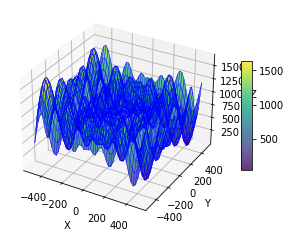

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def schwefel(x1, x2):  
    return 418.9829*2 - x1 * np.sin(np.sqrt(np.abs(x1))) - x2 * np.sin(np.sqrt(np.abs(x2)))

x1 = np.linspace(-500, 500)
x2 = np.linspace(-500, 500)
r_min, r_max = -500, 500

x1, x2 = np.meshgrid(x1, x2)
results = schwefel(x1, x2)

figure = plt.figure()
axis = figure.add_subplot(projection='3d')

# Use a colormap (cmap) to color the surface based on function values
surface = axis.plot_surface(x1, x2, results, cmap='viridis', alpha=0.8)

# Add a color bar to show the mapping of function values to colors
colorbar = figure.colorbar(surface, ax=axis, shrink=0.5, aspect=10)

# Plot wireframe on top of the colored surface
axis.plot_wireframe(x1, x2, results, color='blue', linewidth=0.5)

axis.set_xlabel('X')
axis.set_ylabel('Y')
axis.set_zlabel('Z')
plt.show()


C:\Users\petre\AppData\Local\Temp\ipykernel_5160\3702340856.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


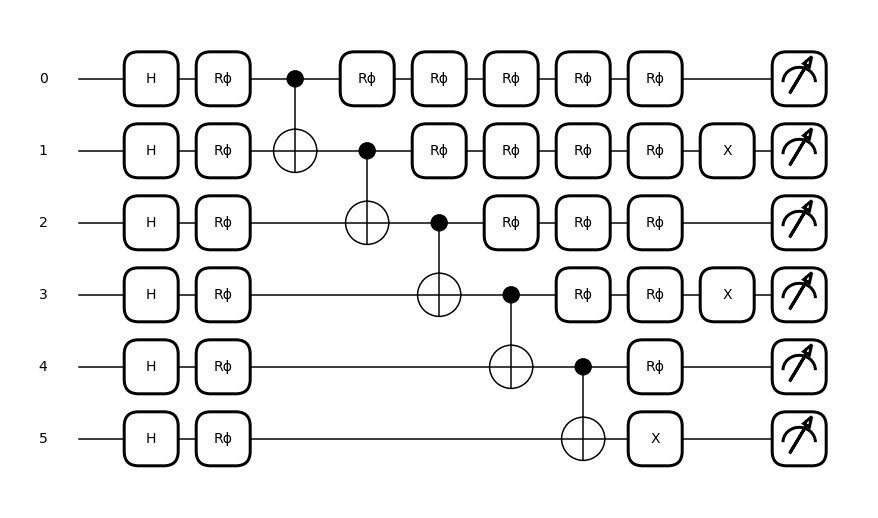

In [71]:
import pennylane as qml

# Define the quantum device
dev = qml.device("default.qubit", wires=6)

# Define the PennyLane QNode
@qml.qnode(dev)
def quantum_circuit(x):
    # Apply Hadamard gates
    for wire in range(6):
        qml.Hadamard(wire)

    # Parametrized PauliZ gates
    for wire in range(6):
        qml.PhaseShift(x[wire], wires=wire)

    # CNOT gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 4])
    qml.CNOT(wires=[4, 5])

    # Parametrized PauliZ gates
    for wire in range(6):
        for other_wire in range(wire + 1, 6):
            qml.PhaseShift(x[wire] * x[other_wire], wires=[wire])

    # X gates
    for wire in range(1, 6, 2):
        qml.PauliX(wire)

    return [qml.expval(qml.PauliZ(i)) for i in range(6)]

# Random values for the parameters
x_values = [1, 1, 1, 1, 1, 1]

# Visualize the circuit using Matplotlib
fig, ax = qml.draw_mpl(quantum_circuit)(x_values)
fig.show()


In [72]:
# 6 qubits, 6 parameters genetic optimization
import pennylane as qml

# Define the quantum device
dev = qml.device("default.qubit", wires=6)

# Define the PennyLane QNode
@qml.qnode(dev)
def quantum_circuit(x):
    # Apply Hadamard gates
    for wire in range(6):
        qml.Hadamard(wire)

    # Parametrized PauliZ gates
    for wire in range(6):
        qml.PhaseShift(x[wire], wires=wire)

    # CNOT gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 4])
    qml.CNOT(wires=[4, 5])

    # Parametrized PauliZ gates
    for wire in range(6):
        for other_wire in range(wire + 1, 6):
            qml.PhaseShift(x[wire] * x[other_wire], wires=[wire])

    # X gates
    for wire in range(1, 6, 2):
        qml.PauliX(wire)

    return [qml.expval(qml.PauliZ(i)) for i in range(6)]

def cost(params):
    return quantum_circuit(params)

# Genetic algorithm parameters
NP = 20
G = 200

# Initialize a population of parameter vectors
D = 6  # Number of parameters in the circuit
population = [np.random.uniform(-np.pi, np.pi, D) for _ in range(NP)]
evaluations = [cost(parameters) for parameters in population]

for i in range(G):
    new_population = [parameters.copy() for parameters in population]

    for j in range(NP):
        parent_A = population[j]
        parent_B = population[np.random.choice(range(NP), replace=False)]

        offspring_AB = crossover(parent_A, parent_B)

        # Apply mutation to the offspring
        offspring_AB = mutate(offspring_AB, mutation_rate=0.1)

        offspring_evaluation = cost(offspring_AB)

        if offspring_evaluation < evaluations[j]:
            new_population[j] = offspring_AB
            evaluations[j] = offspring_evaluation

    population = new_population

# At the end of the algorithm, you can find the best individual in the population
best_parameters = population[np.argmin(evaluations)]
best_evaluation = min(evaluations)
print("Best Parameters:", best_parameters)
print("Best Evaluation (Cost):", best_evaluation)


Best Parameters: [tensor(-0.62014465, requires_grad=True), tensor(2.80133402, requires_grad=True), tensor(0.69516698, requires_grad=True), tensor(-2.97406827, requires_grad=True), tensor(-2.99066697, requires_grad=True), tensor(-1.36243154, requires_grad=True)]
Best Evaluation (Cost): [tensor(-6.66133815e-16, requires_grad=True), tensor(-2.22044605e-16, requires_grad=True), tensor(-2.22044605e-16, requires_grad=True), tensor(-5.55111512e-17, requires_grad=True), tensor(-1.11022302e-16, requires_grad=True), tensor(5.55111512e-17, requires_grad=True)]


In [73]:
import torch
numeric_values = [tensor.item() for tensor in best_parameters]

print(numeric_values)

[-0.6201446480115116, 2.8013340196166308, 0.6951669831107108, -2.974068265148855, -2.990666968188243, -1.3624315391947726]


In [ ]:
import pennylane as qml
import pennylane.numpy as np

# Define the quantum device
dev = qml.device("default.qubit", wires=6)

# Define the PennyLane QNode for the new quantum circuit
@qml.qnode(dev)
def quantum_circuit(x):
    # Apply Hadamard gates
    for wire in range(6):
        qml.Hadamard(wire)

    # Parametrized PauliZ gates
    for wire in range(6):
        qml.PhaseShift(x[wire], wires=wire)

    # CNOT gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 4])
    qml.CNOT(wires=[4, 5])

    # Parametrized PauliZ gates
    for wire in range(6):
        for other_wire in range(wire + 1, 6):
            qml.PhaseShift(x[wire] * x[other_wire], wires=[wire])

    # X gates
    for wire in range(1, 6, 2):
        qml.PauliX(wire)

    return [qml.expval(qml.PauliZ(i)) for i in range(6)]

# Make the parameters trainable
x = np.random.rand(15)  # Update the size based on the number of parameters in your circuit
x = np.array(x, requires_grad=True)

# Define the QNode for optimization
@qml.qnode(dev)
def circuit(x):
    return np.mean(quantum_circuit(x))  # Use the mean of the expectation values as the cost

# Optimize the parameters
opt = qml.GradientDescentOptimizer(stepsize=0.1)
n_it = 100

for it in range(n_it):
    x, prev_cost = opt.step_and_cost(circuit, x)
    if it % 10 == 0:
        print('Parameters:', x, 'Cost:', prev_cost)
